# Building an image similarity system with 🤗 Datasets FAISS

This is follow-up notebook of the tutorial introduced in [this PR](https://github.com/huggingface/notebooks/pull/270). 🤗 Datasets supports a [FAISS](https://github.com/facebookresearch/faiss) integration that is useful for building similarity systems. You can learn more about this integration [here](https://huggingface.co/docs/datasets/faiss_es).

## Installations

In [ ]:
!pip install transformers datasets faiss-cpu -q

     |████████████████████████████████| 5.8 MB 7.4 MB/s 
     |████████████████████████████████| 451 kB 37.2 MB/s 
     |████████████████████████████████| 17.0 MB 3.7 MB/s 
     |████████████████████████████████| 182 kB 52.3 MB/s 
     |████████████████████████████████| 7.6 MB 29.7 MB/s 
     |████████████████████████████████| 212 kB 9.8 MB/s 
     |████████████████████████████████| 132 kB 18.6 MB/s 
     |████████████████████████████████| 127 kB 42.8 MB/s 


## Load model for computing embeddings of the candidate images

In [ ]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/756 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load candidate subset

In [ ]:
from datasets import load_dataset


seed = 42
num_samples = 100
dataset = load_dataset("beans", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


## Extract embeddings

In [ ]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [ ]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

## Load test set for querying

In [ ]:
test_ds = load_dataset("beans", split="test")

## Select a random sample and run the query

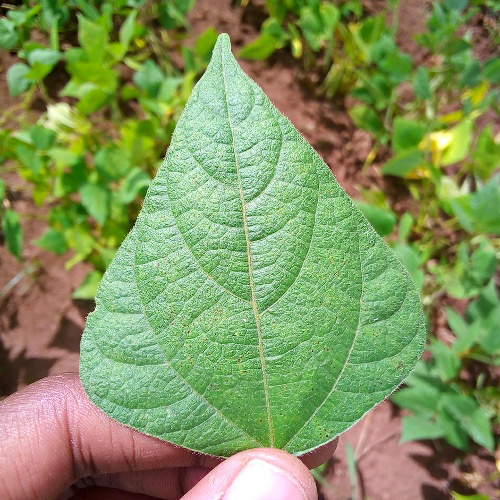

In [ ]:
import numpy as np


random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [ ]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


scores, retrieved_examples = get_neighbors(query_image)

In [ ]:
# Reference: 
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion_jax_how_to.ipynb

from PIL import Image 


def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

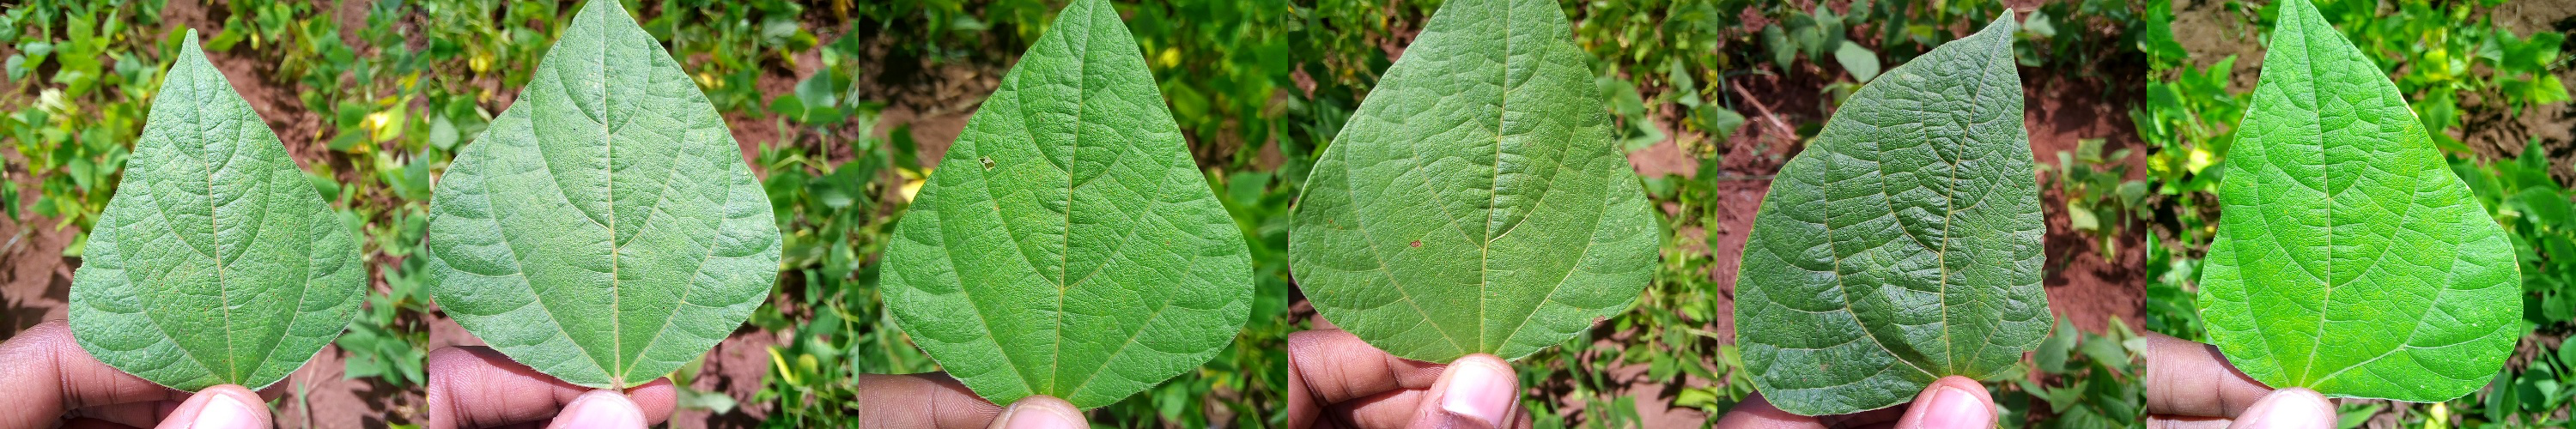

In [ ]:
images = [query_image]
images.extend(retrieved_examples["image"])


image_grid(images, 1, len(images))